In [17]:
#librerías
import numpy as np
import matplotlib.pyplot as plt #gráficos
from scipy import interpolate #interpolación 1
from scipy.interpolate import griddata #interpolación 2
import h5py #archivos en hdf5
from jupyterlab_h5web import H5Web #librería
from pathlib import Path, PurePath #manejo de rutas y archivos
%run -i ./Funciones_campo_B.py #funciones importante
from scipy.interpolate import UnivariateSpline
from scipy.constants import e, m_e, epsilon_0 #constantes físicas
idioma = 'español'

if idioma == 'español':
    #plt.prop_cycle(color=['0C5DA5', '00B945', 'FF9500', 'FF2C00', '845B97'])
    #axes.prop_cycle : cycler('color', ['0C5DA5', '00B945', 'FF9500', 'FF2C00', '845B97', '474747', '9e9e9e'])
    #Latex y coma como separador decimal
    plt.rcParams['text.usetex'] = True #latex
    #plt.rc('text', usetex=False)
    plt.rcParams['axes.formatter.use_locale'] = True #formato de eje para la coma
    #se incluye paquete matematico útil, se corrige el error con el espacio y el espacio entre los números
    plt.rc('text.latex', preamble=r'\usepackage{amsmath} \DeclareUnicodeCharacter{202F}{\,} \usepackage{ziffer} \usepackage{siunitx}') 
    plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
    })
    import locale #líbreria para el formato
    locale.setlocale(locale.LC_ALL, "es_CR.utf8")

if idioma == 'ingles' :
    plt.rc('text.latex', preamble=r'\usepackage{amsmath} \usepackage{siunitx}')
    plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
    })


In [8]:
#Valor de campo eléctrico en la región de interées
def campo_E(archivo, a, a1, b, c, d) :
    import cmocean #https://matplotlib.org/cmocean/ mapas de colores finos
    #https://stackoverflow.com/questions/26065811/same-color-bar-range-for-different-plots-matplotlib
    ruta_archivo = PurePath(Path(archivo)) #archivo 
    with h5py.File(ruta_archivo,'r') as E_rms_hdf5: #lectura archivo hdf
        E_rms = E_rms_hdf5[a][...][...]
        f_0 = 2.45e9
        lamb = c/f_0
        
        f = 0.45
        nfa_r = 0.75*f
        nfa_z = 0.75*f
        deltar1 = -0.004
        deltar2 = 0
        deltaz1 = 0
        deltaz2 = 0
        r_1 = -0.4161034431 + lamb*nfa_r + deltar1
        r_2 = 0.9179012429 - lamb*nfa_r + deltar2
        z_1 = -0.6421370829 + lamb*nfa_z + deltaz1
        z_2 = 0.6421370829 - lamb*nfa_z + deltaz2
        
        r = np.linspace(r_1, r_2, 2779) 
        z = np.linspace(z_1, z_2, 2681) 
        #coordenadas que cumplen la condición
        r_indices = np.where( (r >= a1) & (r <= b) )
        z_indices = np.where((z>= c) & (z <= d)  )
        
        #coordenadas nuevas
        r_nueva = r[r_indices]
        z_nueva = z[z_indices]
        rr , zz = np.meshgrid(r_indices[0], z_indices[0]) #construir malla de coordenadas
        E_rms_final = E_rms[rr, zz] #Asigna las coordenadas malla para obtener los valores
        return E_rms_final, r_nueva, z_nueva

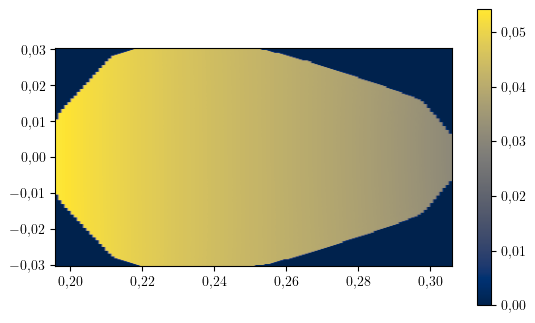

In [9]:
#Valores de campo magnético
ruta_campo = 'ne_Te_r_z_B/r+z+B_mag_componentes.txt'
r_BS, z_BS, B_x,B_y,B_z = np.loadtxt(ruta_campo, usecols=(0, 1, 2, 3, 4), unpack=True)
s2DB = campo_magnetico_mapa(r_BS, z_BS)
B_xint, B_yint, B_zint = input_campo(s2DB, B_x, B_y, B_z)

In [58]:
#Cálculo de A
def A_SEH_plot(B_x, B_y, B_z, archivo, a, a1, b, c, d) :

    #Gradiente de E
    E, r_n, z_n = campo_E(archivo, a, a1, b, c, d)
    delta_x = r_n[1]-r_n[0]
    delta_y = np.abs(z_n[1]-z_n[0])
    P_ent = 2
    radio = 3.65e-2
    #A_1 = 0.461802 #superficie normal
    A_2 = np.pi*radio**2 #cámara de vacío
    I = (P_ent)/(A_2)
    E_0 = np.sqrt((2*I)/(epsilon_0*3e8))
    print("E_0 es", E_0)
    E_gradiente_R, E_gradiente_z = np.gradient((E*E_0), delta_x, delta_y) 
    E_grad = np.sqrt(E_gradiente_R**2 + E_gradiente_z**2)
    #E_gradiente_R, E_gradiente_z = np.gradient(E, delta_x, delta_y) 
    #E_grad = np.sqrt(E_gradiente_R**2 + E_gradiente_z**2)
    
    #Campo magnético
    B = np.sqrt( np.power(B_xint,2) + np.power(B_yint,2) + np.power(B_zint,2) )
    
    #Parámetro
    #print(B.shape, E.shape)
    A_SEH = np.abs( m_e/(e*np.power(B, 2)) * E_gradiente_R )
    A_SEH[np.isinf(A_SEH)] = 0
    print(np.max(A_SEH))
    grid_r, grid_z = np.mgrid[0.19893:0.303797:127j, -0.0289025:0.0289019:229j]
    #Región híbrida superior
    
    wuh_norm = np.loadtxt('./regiones_importantes/wuh_A_SEH.txt')
    v_min = np.min(A_SEH)
    v_max = np.max(A_SEH)
    cmap = 'inferno'
    levels = np.linspace(v_min, v_max, 200)
    levels1 = np.arange(1.0, 1.01, 1) #O mode cut-off
    
    #Gráficos
    fig, ax = plt.subplots()
    A_SEH_plot = ax.contourf(r_n, z_n,  A_SEH, extent=(a1,b,c,d), alpha=0.9, 
                  vmin = v_min, vmax = v_max, levels=levels, cmap=cmap) #correcto
    uh = ax.contour(grid_r,grid_z, wuh_norm, levels1, linestyles = 'dashed', colors = '#008026', linewidths = 1)
    
    ax.set_ylabel(r'$ z \left( \si{\metre} \right) $', 
                  fontdict = {'fontsize':14, 'fontweight':'bold', 'color':'black'}, labelpad = -5)
    ax.set_xlabel(r'$ R \left( \si{\metre} \right) $',  
                  fontdict = {'fontsize':14, 'fontweight':'bold', 'color':'black'})
    ax.tick_params(axis='both', labelsize=14, width=1.5)
    
    #Produce una barra del mismo tamaño del gráfico
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    
    ac = plt.colorbar(A_SEH_plot, cax=cax, orientation='vertical', shrink=0.8)
    ac.set_label(r' $A_{SEH}\left( \si{1} \right)$', rotation=270, 
                  fontdict = {'fontsize':14, 'fontweight':'bold', 'color':'black'}, labelpad=15) #labelpad - alejar
    ac.ax.tick_params(labelsize=14, width=1.5)
    ax.set_aspect("equal")
    plt.setp(ax.spines.values(), linewidth=1.5)
    ac.outline.set_linewidth(1.5) #ancho del borde de la barra
    #ac.set_ticks(np.arange(0,0.0007143122209752268, 0.0002+0.00001)) #B=B0
    
    cont_0,_ = uh.legend_elements()
    plt.legend([cont_0[0]], [r'{$\omega = \omega_{UH}$}',], fontsize = 11, loc='upper center', 
               frameon=True,  bbox_to_anchor=(-17, 1.0),   ncol=1,  fancybox=True, shadow=True)
    #plt.savefig('A_SEH_sc.png', dpi=300, bbox_inches='tight')
    #plt.savefig('A_SEH_cc.png', dpi=300, bbox_inches='tight')
    plt.close() #no mostrar el gráfico cuando se visualiza en el tiempo
    return A_SEH, uh, r_n, z_n

In [59]:
a_seh, UH, r, z = A_SEH_plot(B_xint, B_yint, B_zint, './campo_E/fileout_v46_camara_1.h5', 'T0003__E_rms', 0.1957178997475323, 0.3060799,
               -0.03031574, 0.03031574)

E_0 es 599.8286460683754
2.7751300492628546e-06


/tmp/ipykernel_73526/4217190359.py:25: RuntimeWarning: divide by zero encountered in true_divide
  A_SEH = np.abs( m_e/(e*np.power(B, 2)) * E_gradiente_R )


In [60]:
def A_SEH_en_pos(A_SEH, uh, angulo, num, r_n, z_n) :
    for item1 in uh.collections:
        for i11 in item1.get_paths():
            v11 = i11.vertices
            x11 = v11[:, 0]
            y11 = v11[:, 1]
        
    #Interpolar un contorno: https://stackoverflow.com/questions/33962717/interpolating-a-closed-curve-using-scipy
    tck11, _ = interpolate.splprep([x11, y11], s=0, per=True)
    
    # Evaluar el contorno
    x11_inter, y11_inter = interpolate.splev(np.linspace(0, 1, num), tck11)
    print(x11_inter.shape, y11_inter.shape)
    
    #Asignacion
    x_pos_uhr = x11_inter
    y_pos_uhr = y11_inter    
    angulo_uhr = np.arctan2(-y_pos_uhr, (x_pos_uhr-0.247))
    index = find_nearest1(angulo_uhr, np.radians(angulo))
    x_uhr = x_pos_uhr[index] - 0.00860
    y_uhr = y_pos_uhr[index] + 0.009999
    
    #Interpolación 2D para ajustar con el contorno
    r1 = np.linspace(np.min(r_n), np.max(r_n), num)
    z1 = np.linspace(np.min(z_n), np.max(z_n), num)
    from scipy.interpolate import RegularGridInterpolator as RGI
    r = RGI((r_n, z_n), A_SEH.T, method='cubic', bounds_error=False, fill_value=None)
    rrnew, zznew = np.meshgrid(r1, z1, indexing='ij', sparse=True)
    A_SEH_interpolado = r((rrnew, zznew))
    
    #Asignación del indice buscado para el ángulo
    ind_A_SEH_r = np.searchsorted(r1, x_uhr, side="left")
    ind_A_SEH_z = np.searchsorted(z1, y_uhr, side="left")
    A_SEH_final = np.max(A_SEH_interpolado)
    #A_SEH_final = A_SEH_interpolado[ind_A_SEH_r.astype(int), ind_A_SEH_z.astype(int)]
    print(A_SEH_final, x_uhr, y_uhr)
    return A_SEH_final

In [21]:
A_SEH_en_pos(a_seh, UH, -13, 200, r, z)

(200,) (200,)
5.177010503014385e-09 0.2771057327392265 0.01821871094733596


5.177010503014385e-09

In [63]:
def plot_SEH_en_t(B_x, B_y, B_z, archivo, a1, b, c, d):
    conversion = np.array(['T0019__E_abs', 'T0026__E_abs', 'T0033__E_abs', 
                           'T0040__E_abs', 'T0047__E_abs', 'T0054__E_abs',
                           'T0061__E_abs', 'T0068__E_abs', 'T0075__E_abs',
                           'T0082__E_abs', 'T0089__E_abs', 'T0096__E_abs'])
    periodo = np.array([19, 26, 33, 40, 47, 54, 61, 68, 75, 82, 89, 96])*(1/2.45)
    n_filas = np.shape(periodo)[0]
    A_SEH_almacenado =  np.ndarray((n_filas,), dtype=np.float64) #matriz para almacenar
    for i in range(0,n_filas):
        print(conversion[i])
        a_seh, UH, r, z = A_SEH_plot(B_x, B_y, B_z, archivo, conversion[i], a1, b, c, d)
        A_SEH_almacenado[i] = A_SEH_en_pos(a_seh, UH, 18, 200, r, z)
    color = '#845B97'
    plt.plot(periodo, A_SEH_almacenado, '--o', color = color)
    plt.xlabel(r'$t$ (\si{\nano\second})', fontdict = {'fontsize':14, 'fontweight':'bold', 'color':'black'})
    plt.ylabel( r'$A_{SEH}$ (1)', fontdict = {'fontsize':14, 'fontweight':'bold', 'color':'black'})
    plt.tick_params(axis='both', labelsize=14, width=1.5)
    ax = plt.gca()
    plt.ylim(0.02, 0.09+0.0001)
    plt.setp(ax.spines.values(), linewidth=1.5)
    #plt.savefig('A_SEH_t_cc.png', dpi=300, bbox_inches='tight')
    plt.savefig('A_SEH_t_ingles.png', dpi=300, bbox_inches='tight')

T0019__E_abs
E_0 es 599.8286460683754
0.022254888196200133


/tmp/ipykernel_73526/4217190359.py:25: RuntimeWarning: divide by zero encountered in true_divide
  A_SEH = np.abs( m_e/(e*np.power(B, 2)) * E_gradiente_R )


(200,) (200,)
0.02247725420456811 0.27335003252920365 -0.0014659735109373
T0026__E_abs
E_0 es 599.8286460683754
0.04375523381123594
(200,) (200,)
0.04268897452283358 0.27335003252920365 -0.0014659735109373
T0033__E_abs
E_0 es 599.8286460683754
0.05811008911248574
(200,) (200,)
0.05796238583158588 0.27335003252920365 -0.0014659735109373
T0040__E_abs
E_0 es 599.8286460683754
0.06409592729951437
(200,) (200,)
0.06540456903996945 0.27335003252920365 -0.0014659735109373
T0047__E_abs
E_0 es 599.8286460683754
0.0661533901785454
(200,) (200,)
0.061559264883053535 0.27335003252920365 -0.0014659735109373
T0054__E_abs
E_0 es 599.8286460683754
0.06285477462833869
(200,) (200,)
0.05944853871856546 0.27335003252920365 -0.0014659735109373
T0061__E_abs
E_0 es 599.8286460683754
0.06446188454104397
(200,) (200,)
0.06099758177814213 0.27335003252920365 -0.0014659735109373
T0068__E_abs
E_0 es 599.8286460683754
0.07275478332580951
(200,) (200,)
0.07059055893775315 0.27335003252920365 -0.0014659735109373
T0

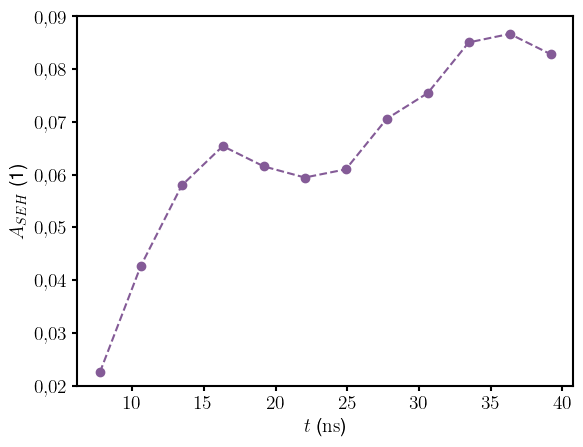

In [64]:
plot_SEH_en_t(B_xint, B_yint, B_zint, './campo_E/fileout_v46_100T.h5', 0.1957178997475323, 0.3060799,
               -0.03031574, 0.03031574)        